In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# spacy
import spacy

# Gensim
import gensim

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Keras
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping

# Data preparation

In this section data will be loaded, cleaned and lemmatized

In [2]:
# Load data
data = pd.read_json("dataset_1M.json", lines=True)

In [3]:
data.count()

overall           1000000
verified          1000000
reviewTime        1000000
reviewerID        1000000
asin              1000000
style              358331
reviewerName       999917
reviewText         999636
summary            999862
unixReviewTime    1000000
vote               121947
image               16345
dtype: int64

In [4]:
# Remove all non-verified buyers
data = data[data.verified]
data.count()

overall           947137
verified          947137
reviewTime        947137
reviewerID        947137
asin              947137
style             337257
reviewerName      947064
reviewText        946798
summary           947005
unixReviewTime    947137
vote              111510
image              14906
dtype: int64

In [5]:
# Remove all reviews without text
data = data[data.reviewText.notna()]
data.count()

overall           946798
verified          946798
reviewTime        946798
reviewerID        946798
asin              946798
style             337128
reviewerName      946725
reviewText        946798
summary           946674
unixReviewTime    946798
vote              111487
image              14832
dtype: int64

In [6]:
# Leave only "overall", "reviewText" and "summary"
data = data[["overall", "reviewText", "summary"]]
data.head()

,overall,reviewText,summary
1,1,It sucks barely picks up anything definitely n...,sucks
2,1,"Well to write a short one, it blew 2 fuses of ...",Defective
3,3,I have absolutely no memory of buying this but...,Looks cool! Probably works
4,5,it ok it does it job,Five Stars
5,5,Have 3 big dogs. this have been great for my F...,this have been great for my Ford transit connect


In [7]:
# Fill empty summaries
data = data.fillna("")
data.count()

overall       946798
reviewText    946798
summary       946798
dtype: int64

In [8]:
# Join "summary" and "reviewText" into one feature "text"
data["space"] = " "
data["text"] = data["summary"] + data["space"] + data["reviewText"]
data = data[["overall", "text"]]
data.head()

,overall,text
1,1,sucks It sucks barely picks up anything defini...
2,1,"Defective Well to write a short one, it blew 2..."
3,3,Looks cool! Probably works I have absolutely n...
4,5,Five Stars it ok it does it job
5,5,this have been great for my Ford transit conne...


In [121]:
# Remove noise
# Remove HTML
data["text_cleaned"] = data["text"].replace(to_replace="(<.*?>|&nbsp;)", value="", regex=True)
# Remove special characters
data["text_cleaned"] = data["text_cleaned"].replace(to_replace="[.,\/#!$%\^&\*;:{}=\-_`~()]", value="", regex=True)
# Remove numbers
data["text_cleaned"] = data["text_cleaned"].replace(to_replace="[0-9]+", value="", regex=True)
# Remove single character words
data["text_cleaned"] = data["text_cleaned"].replace(to_replace="(?<![\w])(?:[a-zA-Z0-9](?: |$))", value="", regex=True)
# Remove multiple spaces
data["text_cleaned"] = data["text_cleaned"].replace(to_replace=" +", value=" ", regex=True)
# Drop empty
data = data.dropna()

In [108]:
# Lemmatize text
def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = [" ".join([token.lemma_ for token in nlp(text)]) for text in texts]
    return (texts_out)

data["lemmatized_text"] = lemmatization(data["text_cleaned"].values.tolist())

In [28]:
# Split texts into lists of words
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data["split_text"] = gen_words(data["lemmatized_text"].tolist())

In [9]:
file_path = "saved_data/data.csv"

In [185]:
# Save data to file
data.to_csv(file_path, index=False)

In [10]:
# Load data from file
data = pd.read_csv(file_path)

# GloVe Embeddings

Now the GloVe word embeddings will be loaded, and all the words will be converted to indeces that connect them to their respective embeddings

In [16]:
# Load GloVe word embeddings
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

words_to_index, index_to_words, word_to_vec_map = read_glove_vecs("glove.6B/glove.6B.50d.txt")

In [31]:
# Convert text to embeddings
def convert_to_indeces(texts):
    return [[words_to_index[word] for word in line if word in words_to_index] for line in texts]

data["text_indeces"] = convert_to_indeces(data["split_text"].tolist())

In [180]:
# Let's see what length to pad the reviews to
data["text_indeces"].apply(lambda x: len(x)).describe()

count    946659.000000
mean         36.065825
std          50.910704
min           1.000000
25%           8.000000
50%          21.000000
75%          44.000000
max        3328.000000
Name: text_indeces, dtype: float64

In [37]:
# Pad and truncate to 100 words
data["text_indeces_padded"] = pad_sequences(data["text_indeces"].tolist(), maxlen=100, padding="post", truncating="post").tolist()

In [50]:
# Normalize target variable
data["y"] = data["overall"].apply(lambda x : x/5)

In [51]:
# Drop empty
data = data.dropna()

# Simple LSTM Model

Now an LSTM model will be trained on the data

In [56]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data["text_indeces_padded"].tolist(), data["y"].tolist(), test_size=0.02)

In [57]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [75]:
# Define pretrained Embedding layer using GloVe
def pretrained_embedding_layer(word_to_vec_map, words_to_index):
    vocab_size = len(words_to_index) + 1
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
      
    emb_matrix = np.zeros([vocab_size,emb_dim])

    for word, idx in words_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = layers.Embedding(vocab_size, emb_dim ,trainable = False)

    embedding_layer.build((None,))

    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [76]:
# Define LSTM model
def LSTM_regression_model(input_shape, word_to_vec_map, words_to_index, drop_out=0.2):  

    sentence_indices = layers.Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    
    X = layers.LSTM(units=128, return_sequences = True, dropout=drop_out)(embeddings)
    X = layers.LSTM(units=128, return_sequences = False, dropout=drop_out)(X)
    X = layers.Dense(32, activation="relu")(X)
    X = layers.Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [79]:
model = LSTM_regression_model((X_train.shape[1],), word_to_vec_map, words_to_index)

In [81]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          91648     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,227,443
Trainable params: 227,393
Non-trainable params: 20,000,050
___________________________________________

In [86]:
model.compile(optimizer='adam', loss="mean_squared_error", metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])

In [88]:
# Fit the model
early_stopping_monitor = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0.005,
    patience=40,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping_monitor],
    validation_data=(X_test, y_test)
)

Epoch 1/10
14496/14496 [==============================] - 191s 13ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 2/10
14496/14496 [==============================] - 191s 13ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 3/10
14496/14496 [==============================] - 191s 13ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 4/10
14496/14496 [==============================] - 191s 13ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 5/10
14496/14496 [============

In [124]:
# Function to summarize history for loss
def summarize_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

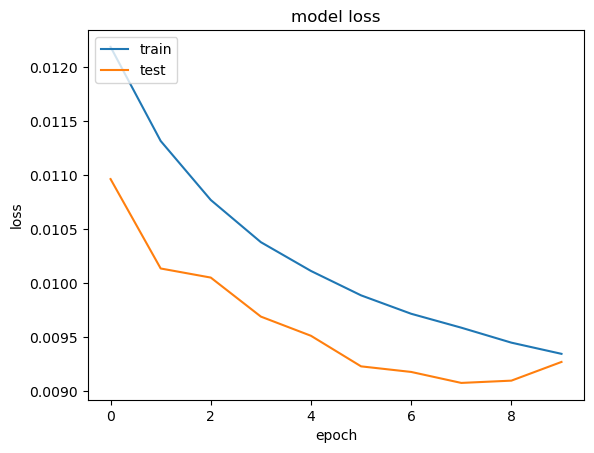

In [132]:
summarize_history(history)

In [181]:
# Function to make predictions from test set and calculate mse, rmse, r2
def evaluate_test(model, X_test, y_test):
    prediction = model.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction)
    print(f"mse = {mse}")
    print(f"rmse = {rmse}")
    print(f"r2 = {r2}")

In [182]:
evaluate_test(model, X_test, y_test)

mse = 0.009270556893447556
rmse = 0.09628373119820169
r2 = 0.76567899511064


In [200]:
# Function to plot histograms
def plot_histogram(model, X_test, y_test):
    prediction = model.predict(X_test)
    prediction = np.reshape(prediction, (prediction.shape[0],))
    df = pd.DataFrame()
    df["prediction"] = prediction * 5
    df["target"] = y_test * 5
    target_df = df.groupby(by="target")
    plt.style.use('ggplot')
    plt.title('Histogram of predicted ratings')
    for key in target_df.groups.keys():
        plt.hist(target_df.get_group(key)['prediction'], bins=30, edgecolor='black', alpha=0.5, density=True)
    plt.legend(list(range(1,6)))
    plt.show()

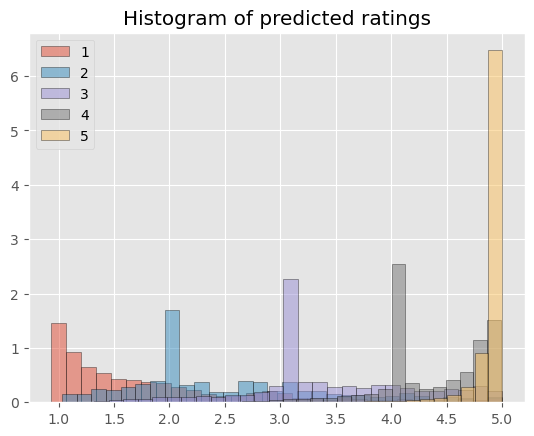

In [201]:
plot_histogram(model, X_test, y_test)

In [117]:
model.save("./model_weights/LSTM_model")

INFO:tensorflow:Assets written to: ./model_weights/LSTM_model\assets


INFO:tensorflow:Assets written to: ./model_weights/LSTM_model\assets


In [175]:
model = keras.models.load_model("./model_weights/LSTM_model")

# Results

As we can see the model has achieved **MSE** of **0.009**, **RMSE** of **0.096** and **R2** of **0.766**. RMSE of 0.096 means that on average the model's prediction is 0.096 off from the real value, however considering the fact that the dataset is highly imbalanced in favour of 5 scores this doesn't tell much. R2 of 0.766 means that the model can explain 77% of the target variable's variance, which is certainly high, but could be better. The histograms show peaks around true values, but also show a problem, which is that people can be inconsistent in their reviews and scores as can be seen by the model often misidentifying a score of 4 as 5.


# Bidirectional LSTM model

Now a bidirectional LSTM model will be trained

In [118]:
# Define bidirectional LSTM model
def Bi_LSTM_regression_model(input_shape, word_to_vec_map, words_to_index, drop_out=0.2):  

    sentence_indices = layers.Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    
    X = layers.Bidirectional(layers.LSTM(units=128, return_sequences = True, dropout=drop_out))(embeddings)
    X = layers.Bidirectional(layers.LSTM(units=128, return_sequences = False, dropout=drop_out))(X)
    X = layers.Dense(32, activation="relu")(X)
    X = layers.Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [128]:
b_model = Bi_LSTM_regression_model((X_train.shape[1],), word_to_vec_map, words_to_index)
b_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          183296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 20,585,843
Trainable params: 585,793
Non-trainable params: 20,000,050
_________________________________________

In [129]:
b_model.compile(optimizer='adam', loss="mean_squared_error", metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])

In [130]:
# Fit the model
early_stopping_monitor = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0.005,
    patience=40,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

b_history = b_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping_monitor],
    validation_data=(X_test, y_test)
)

Epoch 1/10
14496/14496 [==============================] - 392s 26ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_root_mean_squared_error: 0.1089
Epoch 2/10
14496/14496 [==============================] - 396s 27ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_root_mean_squared_error: 0.1009
Epoch 3/10
14496/14496 [==============================] - 380s 26ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 4/10
14496/14496 [==============================] - 378s 26ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 5/10
14496/14496 [============

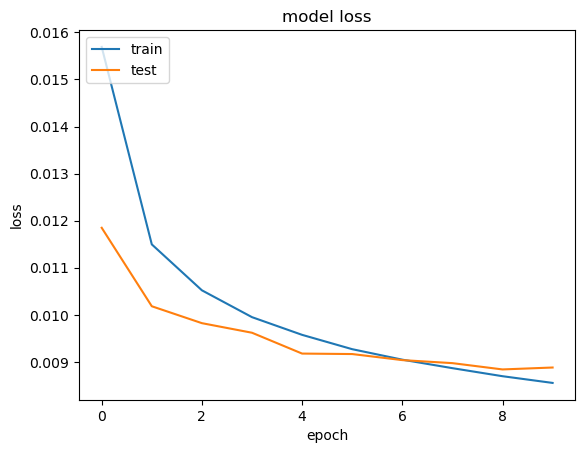

In [133]:
summarize_history(b_history)

In [183]:
evaluate_test(b_model, X_test, y_test)

mse = 0.008879768119644825
rmse = 0.09423252156047203
r2 = 0.7755565050843567


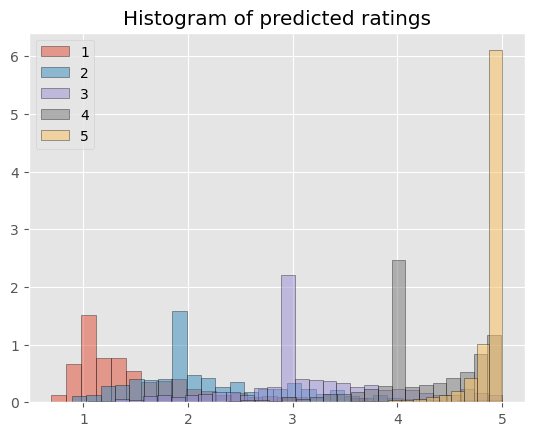

In [202]:
plot_histogram(b_model, X_test, y_test)

In [136]:
b_model.save("./model_weights/b_LSTM_model")

INFO:tensorflow:Assets written to: ./model_weights/b_LSTM_model\assets


INFO:tensorflow:Assets written to: ./model_weights/b_LSTM_model\assets


# Results

We can see a small improvement over the base model, specifically the amount of misidentifications of a score of 4 as 5 is lower